In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV,train_test_split, learning_curve

In [2]:
# Cargamos clean data
df = pd.read_csv('food_crisis/data/clean_food_prices.csv')

Se va a mejorar este modelo aplicando log a la variable objetivo para estabilizar la varianza y reducir la influecia de outliers. 

También, se van a eliminar los valores extremos (outliers) que pueden distorsionar el aprendizaje del modelo. 

In [3]:
# Codificación de variables categóricas
le = LabelEncoder()
df['countryiso3'] = le.fit_transform(df['countryiso3'])  

# Limpieza de outliers
p99 = df['price'].quantile(0.99)
df = df[df['price'] < p99]

X = df[['countryiso3', 'admin1', 'admin2', 'market', 'commodity', 'latitude', 'longitude', 'category', 'unit', 'priceflag', 'pricetype', 'currency', 'year', 'month', 'day', 'weekday']]

# Convierte variables categóricas en variables dummy
X = pd.get_dummies(X)

# Definimos la variable objetivo y la transformamos aplicando log 
y = np.log1p(df['price'])

In [4]:
# Escalado de las características
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# División en datos de entrenamiento y datos de prueba
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

## Entrenamiento de modelo Random Forest
El Random Forest es un modelo que se basa en el conjunto de múltiples árboles de decisión. Cada árbol predice un valor y el valor final es el promedio de las predicciones de los árboles. 

Es muy eficaz para manejar datos con alta dimensionalidad y es menos propenso al sobreajuste.

* n_estimators: Es el número de árboles, y a mayor número, mejor se generaliza el modelo pero a costa de que aumenta el tiempo de computación. 

* max_depth: Es la profundidad máxima de los árboles, lo que se usa para evitar el sobreajuste.

* random_state: Es la semilla para la aleatorización, que sirve para que el modelo sea reproducible.

In [5]:
# Crear el modelo Random Forest
rf = RandomForestRegressor(random_state=42)

### Ajuste de hiperparámetros del Random Forest 

In [ ]:
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [10, None],
    'min_samples_split': [2, 5]
}
grid_search = RandomizedSearchCV(rf, 
                                 param_distributions=param_grid,
                                 n_iter=5, 
                                 cv=3, 
                                 scoring='neg_mean_squared_error', n_jobs=1)


In [ ]:
# Convierte X_train y y_train a DataFrame/Series de pandas y coge muestras
X_train_df = pd.DataFrame(X_train)
y_train_series = pd.Series(y_train)

X_train_df = X_train_df.reset_index(drop=True)
y_train_series = y_train_series.reset_index(drop=True)

X_sample = X_train_df.sample(frac=0.2, random_state=42)
y_sample = y_train_series.loc[X_sample.index]


In [12]:
grid_search.fit(X_sample, y_sample)

best_model = grid_search.best_estimator_

In [ ]:
y_pred_rf = best_model.predict(X_test)

### Importancia de características (Feature Importance)

Se representa en una gráfica de  barras horizontales cuáles son las variables más importantes en orden descendente, de forma que permite visualizar su importancia a la hora de que el modelo pueda predecir el precio (variable objetivo). 
Random Forest calcula cuánta ganacia de información se obtiene en la predicción al usar cada variable.

La importancia es el grado en que esa característica influye en las predicciones, y se encuentra entre 0 y 1 y su suma total es 1. 


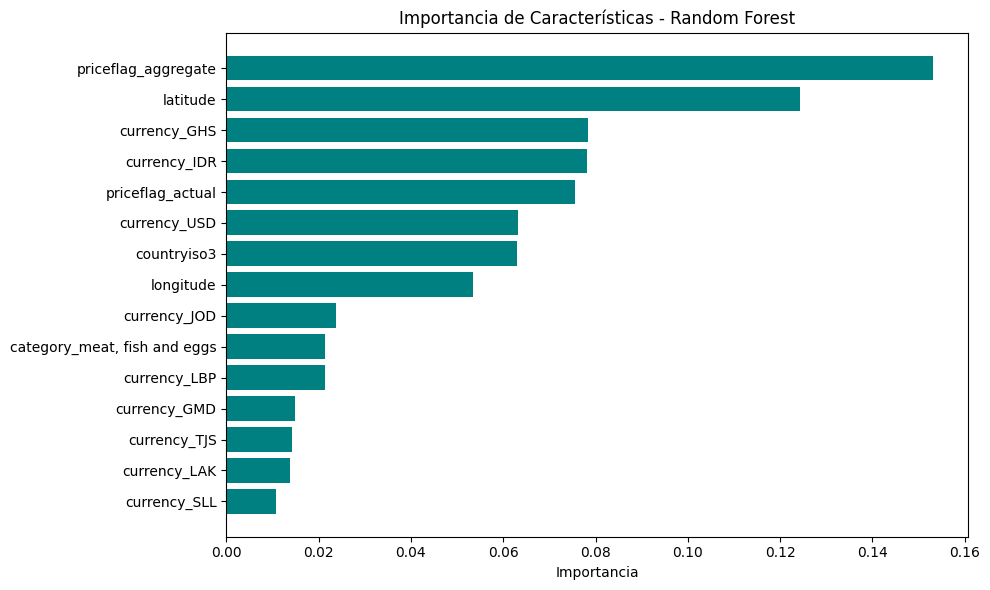

In [23]:
importances = best_model.feature_importances_
indices = np.argsort(importances)[-15:]  # Top 15

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], color='teal', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel("Importancia")
plt.title("Importancia de Características - Random Forest")
plt.tight_layout()
plt.savefig("food_crisis/graphics/random_forest/importances2.png")
plt.show()

Estas son las variables con más importancia: 

- commodity_Livestock (sheep, two-year-old male) > Producto oveja macho de 2 años de edad
- unit_20 L
- market_Tehran Market
- commodity_Livestock (Goat)
- commodity_Meat (beef)
- category_meat, fish and eggs


Esto significa que el tipo de producto (commodity) sobre todo carnes y ganado tiene el mayor impacto en el precio. 
La unidad de medida como "20 L" influye mucho seguramente en productos líquidos que suelen comportarse de forma similar en cuanto a precio.

El mercado específico (Tehran Market) es relevante ya que en esa región los precios se ven afectados de forma importante. 


También hay variables con una importancia media como son: "latitude", "longitude", y "priceflag_actual", que aportan valor. La ubicación geográfica influye de forma moderada en el precio del producto, y el tipo de precio también aunque con diferencias entre los precios agregados y los reales.

Las variables con menor importancia puede deberse a que no tienen mucha variabilidad o no están bien representadas o simplementa no aportan valor de predicción al precio. 

### Predicción vs Valor Real

Permite ver visualmente si el modelo hace buenas predicciones. Esto se puede ver que se cumple, ya que los puntos se alinean bastante en la diagonal que sería predicción = valor real. 

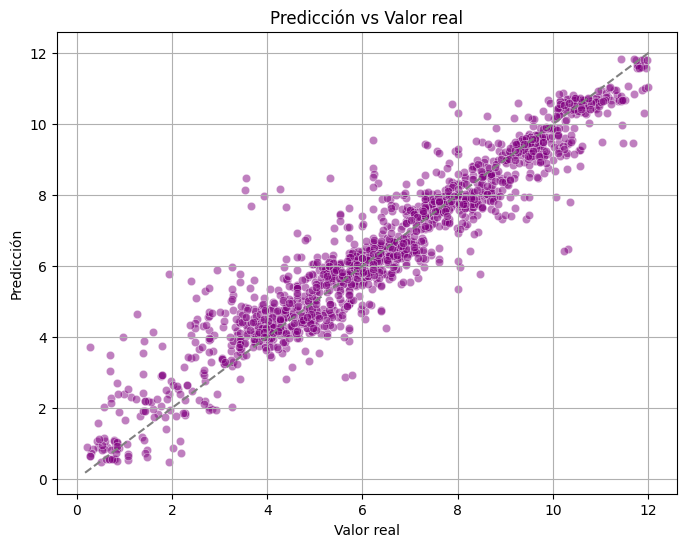

In [30]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, alpha=0.5, color='purple')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--', color='gray')
plt.xlabel("Valor real")
plt.ylabel("Predicción")
plt.title("Predicción vs Valor real")
plt.grid(True)
plt.savefig("food_crisis/graphics/random_forest/predictions2.png")
plt.show()

### Distribución del error o residuos

Se suele representar para ver la distribución de residuos, se calcula la diferencia entre las predicciones y llos valores reales:

> residuo = real - predicho

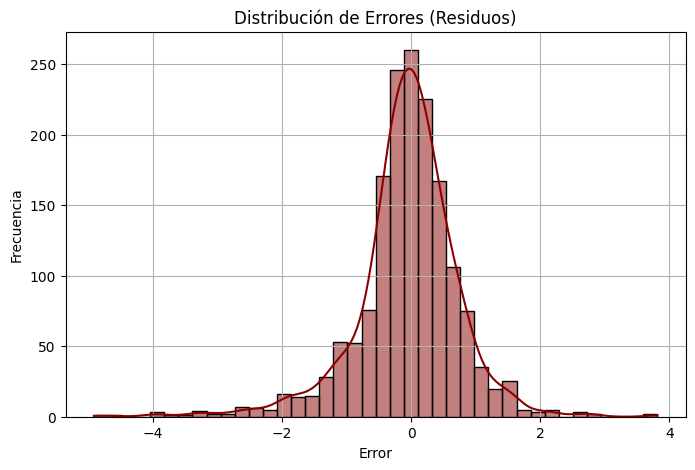

In [25]:
residuals = y_test - y_pred_rf
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=40, kde=True, color='darkred')
plt.title("Distribución de Errores (Residuos)")
plt.xlabel("Error")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.savefig("food_crisis/graphics/random_forest/error_distribution2.png")
plt.show()

La campana es simétrica y se puede ver que está centrada en el cero  y es simétrica sin muchas colas, por lo que tiene errores bajos y bien distribuidos. Esto indica un modelo bien ajustado, y descarta la presencia de sesgo y por tanto las variables importantes están siendo consideradas. 

 ### Curva de aprendizaje (Learning Curve)

La curva de aprendizaje evalua el modelo a medida que aumenta el conjunto de entrenamiento. 

Se usa para ver si el modelo necesita más datos para mejorar su aprendizaje, o si está sobreajustado (overfitting) o subajustado (underfitting).

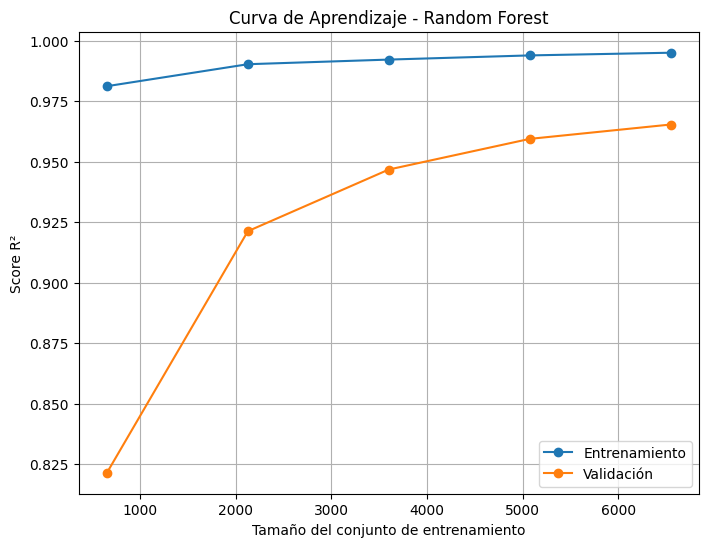

In [19]:
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X, y, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 5), random_state=42
)

train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)

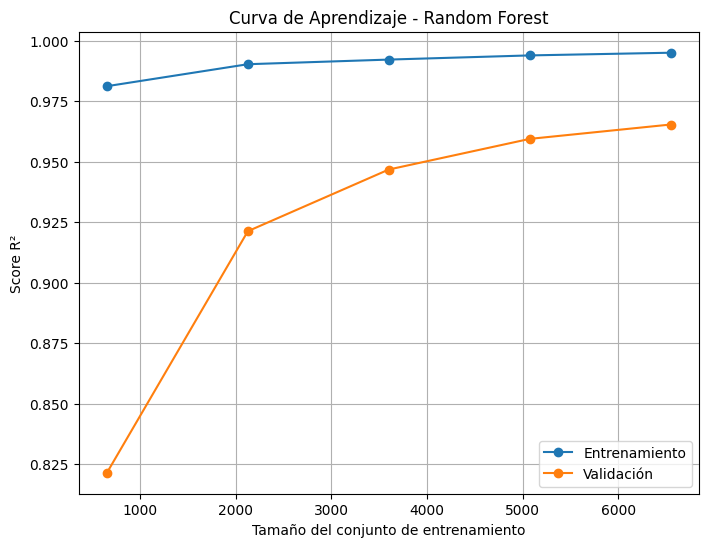

In [26]:
plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_mean, 'o-', label="Entrenamiento")
plt.plot(train_sizes, test_mean, 'o-', label="Validación")
plt.xlabel("Tamaño del conjunto de entrenamiento")
plt.ylabel("Score R²")
plt.title("Curva de Aprendizaje - Random Forest")
plt.legend()
plt.grid(True)
plt.savefig("food_crisis/graphics/random_forest/learning_curve2.png")
plt.show()

Se puede ver que la validación no tiene valores de score  tan altos como el entrenamiento, sobre todo con tamaños pequeños del conjunto de entrenamiento, y a medida que aumenta ese tamaño, aumenta la puntuación.

Respecto al ajuste de hiperparámetros, se puede decir que se ha mejorado el aprendizaje del modelo, ya que con un tamaño de 2000, los valores ya se consideran  más altos y por tanto se obtiene un modelo más balanceado y mejor entrenado. 

### Métricas de Evaluación del modelo

* R^2 o Coeficiente de Determinación
* RMSE: Raíz del MSE 
* MAE: Error Absoluto Promedio 

In [21]:
# Evaluación para el modelo de Random Forest
print("R²:", r2_score(y_test, y_pred_rf))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("MAE:", mean_absolute_error(y_test, y_pred_rf))

R²: 0.905506484968338
RMSE: 0.8046327345153044
MAE: 0.5516189315262919


El valor de R² nos dice que el modelo explica el 90.55% de las variaciones en los datos. Esto significa que el modelo tiene un buen ajuste y está haciendo predicciones bastante precisas en comparación con los datos que realmente observamos.

El RMSE nos da una idea de cuánto se desvían, en promedio, las predicciones del modelo de los valores reales. En este caso, el valor es 0.8046, lo que significa que las predicciones, en promedio, se desvían por 0.8046 unidades de los valores reales. Esto indica que el modelo ha mejorado su precisión y tiene un error relativamente bajo.

Por último, el MAE nos muestra la diferencia promedio entre las predicciones y los valores reales, sin tener en cuenta si el error es positivo o negativo. En este caso, el valor es 0.5516, lo que significa que, en promedio, las predicciones se desvían en 0.5516 unidades de los valores reales. Como este valor es más bajo que el RMSE, podemos decir que el modelo no tiene grandes errores y que los errores están bastante distribuidos de manera uniforme.